# 배터리 B0006 잔여 수명 예측 (PyTorch LSTM)

이 노트북은 NASA에서 공개한 B0006 배터리 데이터를 활용하여 LSTM 기반으로 잔여 수명(RUL)을 예측하는 과정을 정리합니다.

- 데이터 구조 탐색
- 시계열 전처리 및 정규화
- PyTorch LSTM 학습 및 평가


In [30]:
# 기본 라이브러리 및 PyTorch 관련 모듈 불러오기
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

In [31]:
# 재현성을 위한 시드 고정
torch.manual_seed(42)
np.random.seed(42)

### EOL 80% 기준

용량이 초기 용량(2.0Ah)의 80% 이하로 떨어지는 첫 사이클을 EOL로 정의하고, 그 지점까지 남은 사이클 수를 RUL로 사용합니다.

In [44]:
# 메타데이터를 불러와 특정 배터리를 선택
DATA_ROOT = Path("cleaned_dataset")
META_PATH = DATA_ROOT / "metadata.csv"

meta = pd.read_csv(META_PATH)

battery_id = "B0006"

# 선택한 배터리 id에 해당하는 discharge type 데이터 필터링 및 정렬
battery_meta = (
    meta[(meta["type"] == "discharge") & (meta["battery_id"] == battery_id)]
    .sort_values("start_time")
    .reset_index(drop=True)
)

# Capacity 열을 숫자형으로 변환하고 사이클 인덱스 및 RUL 열 추가
battery_meta["Capacity"] = pd.to_numeric(battery_meta["Capacity"], errors="coerce")
battery_meta["cycle_index"] = np.arange(len(battery_meta))
battery_meta["capacity_fraction"] = battery_meta["Capacity"] / 2.0
threshold = 0.8
threshold_idx = battery_meta.index[battery_meta["capacity_fraction"] <= threshold]
if len(threshold_idx) == 0:
    eol_index = len(battery_meta) - 1
else:
    eol_index = threshold_idx[0]
battery_meta["rul_cycle"] = (eol_index - battery_meta["cycle_index"]).clip(lower=0)

display(battery_meta.head())
print(f"사이클 수: {len(battery_meta)}")

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct,cycle_index,capacity_fraction,rul_cycle
0,discharge,[2.0080e+03 4.0000e+00 1.9000e+01 1.3000e+01 1...,24,B0006,53,4558,04558.csv,1.924246,NaN,NaN,0,0.962123,13
1,discharge,[2.0080e+03 4.0000e+00 2.0000e+00 1.5000e+01 2...,24,B0006,1,4506,04506.csv,2.035338,NaN,NaN,1,1.017669,12
2,discharge,[2.0080e+03 4.0000e+00 2.0000e+00 1.9000e+01 4...,24,B0006,3,4508,04508.csv,2.025140,NaN,NaN,2,1.012570,11
3,discharge,[2.0080e+03 4.0000e+00 2.3000e+01 1.0000e+00 1...,24,B0006,93,4598,04598.csv,1.855277,NaN,NaN,3,0.927638,10
4,discharge,[2.0080e+03 4.0000e+00 2.3000e+01 2.1000e+01 2...,24,B0006,109,4614,04614.csv,1.797102,NaN,NaN,4,0.898551,9


사이클 수: 168


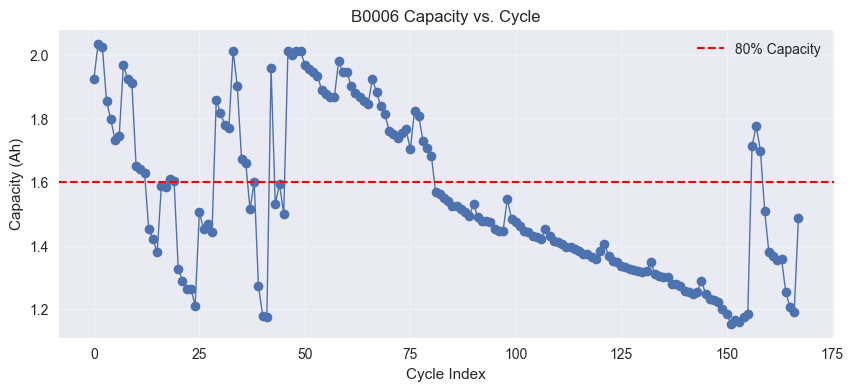

In [45]:
# 용량 감소 추이를 시각화하여 노화 패턴 확인
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(battery_meta["cycle_index"], battery_meta["Capacity"], marker="o", linewidth=1)

# 80% 용량(1.6Ah) 기준선 추가
capacity_threshold = 0.8 * 2.0  # 초기 정격 용량 2.0Ah
ax.axhline(capacity_threshold, color="red", linestyle="--", linewidth=1.5, label="80% Capacity")

ax.set_xlabel("Cycle Index")
ax.set_ylabel("Capacity (Ah)")
ax.set_title(f"{battery_id} Capacity vs. Cycle")
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

In [46]:
# 각 방전 사이클을 균일한 길이로 보간하는 함수 정의
SEQ_LEN = 120
FEATURE_COLS = [
    "Voltage_measured",
    "Current_measured",
    "Temperature_measured",
    "Current_load",
    "Voltage_load",
]

def load_cycle_sequence(filename: str, seq_len: int = SEQ_LEN) -> np.ndarray:
    """
        원본 csv마다 측정 시간이 다르기 때문에 SEQ_LEN 길이로 리샘플링
        -> 고정 길이 텐서로 맞춰주기 위함
    """
    path = DATA_ROOT / "data" / filename
    df = pd.read_csv(path).sort_values("Time")
    time = df["Time"].values
    new_time = np.linspace(time.min(), time.max(), seq_len)
    interpolated = []
    for col in FEATURE_COLS:
        interpolated.append(np.interp(new_time, time, df[col].values))
    return np.stack(interpolated, axis=1)

In [47]:
# 선택한 배터리의 모든 방전 사이클을 시퀀스로 변환
sequences = np.stack(
    [load_cycle_sequence(fname) for fname in battery_meta["filename"]],
    axis=0,
)
targets = battery_meta["rul_cycle"].astype(np.float32).to_numpy()
capacities = battery_meta["Capacity"].astype(np.float32).to_numpy()

print("시퀀스 형태:", sequences.shape)
print("RUL 범위:", targets.min(), targets.max())

시퀀스 형태: (168, 120, 5)
RUL 범위: 0.0 13.0


In [48]:
# 시퀀스를 학습/검증 세트로 분할하고 정규화 수행
train_size = int(len(sequences) * 0.8)

train_meta = battery_meta.iloc[:train_size].copy()
val_meta = battery_meta.iloc[train_size:].copy()

train_X = sequences[:train_size]
val_X = sequences[train_size:]

train_y = targets[:train_size]
val_y = targets[train_size:]

# 지금 사용하진 않지만, 검증 결과를 capacity와 함께 비교할 때 사용할 수 있음
train_cap = capacities[:train_size]
val_cap = capacities[train_size:]

flat_train = train_X.reshape(-1, len(FEATURE_COLS))
mean = flat_train.mean(axis=0)
std = flat_train.std(axis=0) + 1e-6

train_X_norm = ((train_X - mean) / std).astype(np.float32)
val_X_norm = ((val_X - mean) / std).astype(np.float32)

normalizer = {"mean": mean, "std": std, "features": FEATURE_COLS}

print("정규화 평균:", mean)
print("정규화 표준편차:", std)

print("정규화된 학습 시퀀스 형태:", train_X_norm.shape)
print("정규화된 검증 시퀀스 형태:", val_X_norm.shape)

정규화 평균: [ 3.47419729 -1.80867712 32.66615529  0.88697268  2.31657866]
정규화 표준편차: [0.25139872 0.60093793 4.05848261 1.6747682  0.80491271]
정규화된 학습 시퀀스 형태: (134, 120, 5)
정규화된 검증 시퀀스 형태: (34, 120, 5)


In [49]:
# PyTorch Dataset과 DataLoader 정의
class CycleDataset(Dataset):
    def __init__(self, sequences: np.ndarray, targets: np.ndarray):
        self.x = torch.from_numpy(sequences)
        self.y = torch.from_numpy(targets)

    def __len__(self) -> int:
        return len(self.x)

    def __getitem__(self, idx: int):
        return self.x[idx], self.y[idx]

train_dataset = CycleDataset(train_X_norm, train_y.astype(np.float32))
val_dataset = CycleDataset(val_X_norm, val_y.astype(np.float32))

BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

len(train_dataset), len(val_dataset)


(134, 34)

In [50]:
# LSTM 회귀 모델 정의
class LSTMRegressor(nn.Module):
    def __init__(self, input_size: int, hidden_size: int = 64, num_layers: int = 2, dropout: float = 0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output, (hn, _) = self.lstm(x)
        last_hidden = hn[-1]
        prediction = self.fc(last_hidden)
        return prediction.squeeze(-1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMRegressor(input_size=len(FEATURE_COLS)).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 25

model

LSTMRegressor(
  (lstm): LSTM(5, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [51]:
# LSTM 모델 학습 루프
history = {"train_loss": [], "val_loss": []}
best_val = float("inf")
best_state = None

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)

    train_loss /= len(train_dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)

    val_loss /= len(val_dataset)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    if val_loss < best_val:
        best_val = val_loss
        best_state = model.state_dict()

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

if best_state is not None:
    model.load_state_dict(best_state)
    print(f"가장 낮은 검증 손실: {best_val:.4f}")


Epoch 01 | Train Loss: 5.9847 | Val Loss: 0.0438
Epoch 05 | Train Loss: 5.1023 | Val Loss: 0.2343
Epoch 10 | Train Loss: 5.1105 | Val Loss: 0.1253
Epoch 15 | Train Loss: 5.0365 | Val Loss: 0.1683
Epoch 20 | Train Loss: 5.0290 | Val Loss: 0.2051
Epoch 25 | Train Loss: 5.0381 | Val Loss: 0.1672
가장 낮은 검증 손실: 0.0438


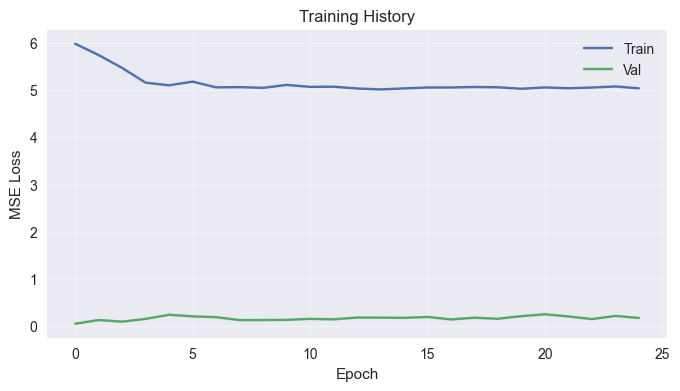

In [52]:
# 학습 및 검증 손실 곡선 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(history["train_loss"], label="Train")
ax.plot(history["val_loss"], label="Val")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE Loss")
ax.set_title("Training History")
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()


In [53]:
# 검증 세트에 대한 예측 및 지표 계산
model.eval()

def predict_dataset(loader: DataLoader):
    preds = []
    targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            preds_batch = model(xb).cpu().numpy()
            preds.append(preds_batch)
            targets.append(yb.numpy())
    return np.concatenate(preds), np.concatenate(targets)

val_preds, val_targets = predict_dataset(val_loader)

val_mae = np.mean(np.abs(val_preds - val_targets))
val_rmse = np.sqrt(np.mean((val_preds - val_targets) ** 2))

print(f"검증 MAE: {val_mae:.3f} 사이클")
print(f"검증 RMSE: {val_rmse:.3f} 사이클")


검증 MAE: 0.167 사이클
검증 RMSE: 0.409 사이클


In [54]:
# 예측 결과를 메타데이터와 결합하여 확인
val_results = val_meta.copy()
val_results = val_results.assign(
    pred_rul=val_preds,
    true_rul=val_targets,
    error=val_preds - val_targets,
)

val_results.loc[:, ["cycle_index", "Capacity", "rul_cycle", "pred_rul", "error"]]


,cycle_index,Capacity,rul_cycle,pred_rul,error
134,134,1.305216,0,-0.047872,-0.047872
135,135,1.300406,0,-0.043062,-0.043062
136,136,1.300236,0,-0.044695,-0.044695
137,137,1.279253,0,-0.050804,-0.050804
138,138,1.279208,0,-0.054157,-0.054157
139,139,1.274037,0,-0.051152,-0.051152
140,140,1.258137,0,-0.059259,-0.059259
141,141,1.253260,0,-0.057949,-0.057949
142,142,1.248087,0,-0.058181,-0.058181
143,143,1.253435,0,-0.059867,-0.059867


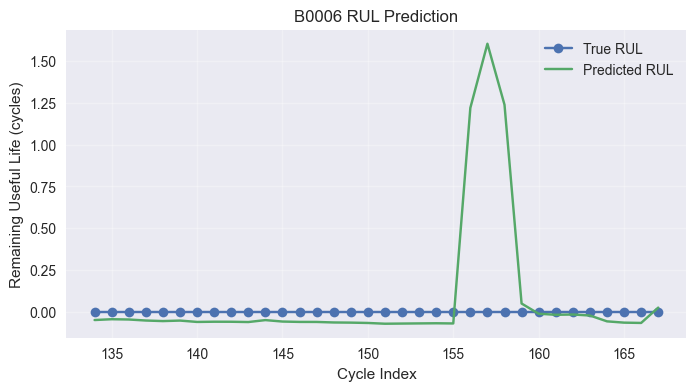

In [55]:
# 실제 RUL과 예측 RUL 비교 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(val_results["cycle_index"], val_results["rul_cycle"], label="True RUL", marker="o")
ax.plot(val_results["cycle_index"], val_results["pred_rul"], label="Predicted RUL", marker="x")
ax.set_xlabel("Cycle Index")
ax.set_ylabel("Remaining Useful Life (cycles)")
ax.set_title(f"{battery_id} RUL Prediction")
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()


## 다음 단계 아이디어

- 다른 배터리 ID에 대해 동일한 파이프라인을 적용해 정확도를 비교할 수 있습니다.
- 시퀀스 길이, 입력 특성 조합, 정규화 방식 등을 바꿔 민감도를 분석해 보세요.
- 하이퍼파라미터 최적화나 GRU, 1D-CNN과 같은 다른 시계열 모델과의 비교도 가치가 있습니다.
